# Exploring Areas of London

## Table of contents
1. [Introduction](#1.-Introduction)
2. [Data](#2.-Data)
3. [Methodology](#3.-Methodology)
4. [Analysis & Machine Learning](#4.-Analysis-&-Machine-Learning)
5. [Results](#5.-Results)
6. [Discussion](#6.-Discussion)
7. [Conclusion](#7.-Conclusion)

## 1. Introduction
London is one of the largest and most important cities of Europe with diverse population of close to 9 million people. It makes a considerable impact upon the arts, commerce, education, entertainment, fashion, finance, healthcare, media, professional services, research and development, tourism and transportation.

In this project we aim to understand the structure of London better: is there a clear distinction between some areas and what is it? For that we will analyse different locations around the city and venues close to them. This should tell us how people use them.

Aside of pure academical interest, our research can help the goverement of London in city development planning.

## 2. Data
For the investigation, the following data sets have been used:
1. [Wikipedia](https://en.wikipedia.org/wiki/List_of_areas_of_London) for areas of London.
2. [Geocoder](https://geocoder.readthedocs.io/) for coordinates of the areas.
3. [Foursquare](https://developer.foursquare.com/docs/places-api/) a source of venues.


## 3. Methodology
### Download all dependencies

In [1]:
!pip install lxml
!pip install geocoder
!pip install plotly
!pip install requests

In [117]:
import pandas as pd
import re # Regex
import geocoder
import plotly.express as px # graphs
import requests # HTTP client
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from collections import Counter

### Loading London locations
Wikipedia is a free source of all different kinds of data. It also has a list of London locations.

In [118]:
dfs = pd.read_html("https://en.wikipedia.org/wiki/List_of_areas_of_London")
df = dfs[1]
df_locations = df.drop(columns=[df.columns[4], df.columns[5]])
df_locations.columns = ["Location", "Borough", "Town", "Postcode"]
df_locations

,Location,Borough,Town,Postcode
0,Abbey Wood,"Bexley, Greenwich [7]",LONDON,SE2
1,Acton,"Ealing, Hammersmith and Fulham[8]",LONDON,"W3, W4"
2,Addington,Croydon[8],CROYDON,CR0
3,Addiscombe,Croydon[8],CROYDON,CR0
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14"
...,...,...,...,...
528,Woolwich,Greenwich,LONDON,SE18
529,Worcester Park,"Sutton, Kingston upon Thames",WORCESTER PARK,KT4
530,Wormwood Scrubs,Hammersmith and Fulham,LONDON,W12
531,Yeading,Hillingdon,HAYES,UB4


#### Cleaning
Borough, Town and Postcode columns have multiple comma-separated values in many cases. We only want to take a single one for geocoding purposes.
There are also numeric references present in some bouroughs which we want to remove.

In [119]:
# turns 'Croydon[8]' into 'Croydon'
def clean_ref(s):
    res = re.search(r'([\w\s,]+)(\[\d+\])?', s)
    if res != None:
        s = res.group(1);
    return s

# returns first of comma-separated values
def head(s):
    return s.split(",")[0]

df_locations.Borough = df_locations.Borough.apply(lambda x: head(clean_ref(x)))
df_locations.Town = df_locations.Town.apply(lambda x: head(x))
df_locations.Postcode = df_locations.Postcode.apply(lambda x: head(x))
df_locations

,Location,Borough,Town,Postcode
0,Abbey Wood,Bexley,LONDON,SE2
1,Acton,Ealing,LONDON,W3
2,Addington,Croydon,CROYDON,CR0
3,Addiscombe,Croydon,CROYDON,CR0
4,Albany Park,Bexley,BEXLEY,DA5
...,...,...,...,...
528,Woolwich,Greenwich,LONDON,SE18
529,Worcester Park,Sutton,WORCESTER PARK,KT4
530,Wormwood Scrubs,Hammersmith and Fulham,LONDON,W12
531,Yeading,Hillingdon,HAYES,UB4


### Add coordinates
We don't have any coordinates in the dataset so far. To get them we will use Geocoder python library with Arcgis provider which doesn't require any API key.

We will also save the resulting dataset to disk, to avoid repeated geocoding for subsequent notebook runs, because that process is slow.

In [133]:
def geocode(address):
    g = geocoder.arcgis(address)
    return g.lat, g.lng

geocoded_file_name = "london_locations.pickle"

try:
    df_locations = pd.read_pickle(geocoded_file_name)
except:
    # add columns for Latitude and Longitude
    df_locations["Lat"] = None
    df_locations["Lng"] = None
    for index, row in df_locations.iterrows():
        # form address line (with UK in the end to avoid London in US and other funny coincidences)
        address = ", ".join([row["Location"], row["Borough"], row["Town"], "UK"])
        lat, lng = geocode(address)
        print(f"({index}){address}: {lat}, {lng}")
        row["Lat"] = lat
        row["Lng"] = lng    
    df_locations.to_pickle(geocoded_file_name)

### Visualize
Let's take a look at the locations on the map.

In [121]:
fig = px.scatter_mapbox(df_locations, lat="Lat", lon="Lng", hover_name="Location", hover_data=["Borough", "Town"],
                        color_discrete_sequence=["fuchsia"], zoom=9, height=600)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

### Foursquare data
We will use Foursquare data to get different venues around these locations.

Foursquare has venues organized into lots of hierarchical categories.
For our purposes we want to query top-level, most generic categories, like 'Food', 'Shops', etc.
So let's get that list first.

In [130]:
FOURSQUARE_CLIENT_ID = 'YQVQAU5W1H13Y1MDLCLZWOCR0TLTP3VC2MJR4RDYSVXAOFD1'
FOURSQUARE_CLIENT_SECRET = 'DB3XN2GZ55M2CKNMKHXCKAU3GZZI3SMGP1FA21CA3MCL1YEU'
FOURSQUARE_VERSION = '20200601'

def query_categories():
    url = 'https://api.foursquare.com/v2/venues/categories'
    params = {
        'client_id': FOURSQUARE_CLIENT_ID, 
        'client_secret': FOURSQUARE_CLIENT_SECRET, 
        'v': FOURSQUARE_VERSION
    }
    results = requests.get(url, params = params).json()
    return results['response']['categories']

top_level_categories = [{
    'id': c['id'],
    'name': c['name'],
} for c in query_categories()]
top_level_categories

[{'id': '4d4b7104d754a06370d81259', 'name': 'Arts & Entertainment'},
 {'id': '4d4b7105d754a06372d81259', 'name': 'College & University'},
 {'id': '4d4b7105d754a06373d81259', 'name': 'Event'},
 {'id': '4d4b7105d754a06374d81259', 'name': 'Food'},
 {'id': '4d4b7105d754a06376d81259', 'name': 'Nightlife Spot'},
 {'id': '4d4b7105d754a06377d81259', 'name': 'Outdoors & Recreation'},
 {'id': '4d4b7105d754a06375d81259', 'name': 'Professional & Other Places'},
 {'id': '4e67e38e036454776db1fb3a', 'name': 'Residence'},
 {'id': '4d4b7105d754a06378d81259', 'name': 'Shop & Service'},
 {'id': '4d4b7105d754a06379d81259', 'name': 'Travel & Transport'}]

Now that we have a list of categories let's explore venues around all locations.
We want to have a dataset with a count of venues of every category for each location.

In [123]:
# Queries Foursquare for places of specified categories at the coordinates
# in 1km radius
def explore(lat, lng, categories=None):
    url = 'https://api.foursquare.com/v2/venues/explore'
    params = {
        'client_id': FOURSQUARE_CLIENT_ID, 
        'client_secret': FOURSQUARE_CLIENT_SECRET, 
        'v': FOURSQUARE_VERSION,
        'll': f'{lat},{lng}', 
        'radius': 1000, 
        'categoryId': categories
    }
    return requests.get(url, params = params).json()
    
    
# Queries Foursquare for all locations in a dataframe
def explore_all(df):
    places = []
    
    for index, row in df.iterrows():
        print(f"({index}){row.Location}")
        place = [row['Location']]
        for category in top_level_categories:
            result = explore(row.Lat, row.Lng, [category['id']])
        
            # read until code is 200 (success)
            while True:
                code = result['meta']['code']
                if code == 200:
                    break
                else:
                    print(result);
                    result = explore(row.Lat, row.Lng, [category['id']])

            num = result['response']['totalResults']
            place.append(num)
        places.append(place)
    
    df1 = pd.DataFrame(places)
    columns = ['Location']
    columns.extend([c['name'] for c in top_level_categories])
    df1.columns = columns
    return df1

try:
    print("Loading")
    places = pd.read_pickle("places_london_all4.pickle")
    print("Loaded places_london_all4.pickle")
except:
    print("Exploring..")
    places = explore_all(df_locations)
    places.to_pickle("places_london_all4.pickle")

places

Loading
Loaded places_london_all4.pickle


,Location,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,Abbey Wood,1,0,0,6,6,5,3,2,7,4
1,Acton,4,5,0,61,14,12,38,6,66,30
2,Addington,0,0,0,6,1,5,4,0,3,3
3,Addiscombe,5,7,0,53,25,8,36,6,82,32
4,Albany Park,1,2,0,5,5,2,6,0,17,2
...,...,...,...,...,...,...,...,...,...,...,...
528,Woolwich,6,11,0,31,11,13,23,8,16,14
529,Worcester Park,2,0,0,12,4,2,7,1,19,4
530,Wormwood Scrubs,9,4,0,113,40,33,40,10,60,19
531,Yeading,0,2,0,5,3,2,5,0,16,3


## 4. Analysis & Machine Learning

### Analyse venues

Let's take a look at most popular venues in London, by their max presence in any location:

In [124]:
venue_counts = places.set_index('Location')
venue_counts_described = venue_counts.describe().transpose().sort_values('max', ascending=False)
venue_counts_described = venue_counts_described.reset_index().rename(columns={'index': 'ategory'})
venue_counts_described

,ategory,count,mean,std,min,25%,50%,75%,max
0,Food,533.0,44.917448,55.979829,0.0,7.0,22.0,57.0,247.0
1,Nightlife Spot,533.0,23.046904,36.504450,0.0,4.0,7.0,22.0,240.0
2,Shop & Service,533.0,32.204503,26.846427,0.0,10.0,21.0,53.0,137.0
3,Travel & Transport,533.0,21.090056,28.533573,0.0,4.0,8.0,23.0,129.0
4,Arts & Entertainment,533.0,9.410882,16.950448,0.0,1.0,3.0,8.0,125.0
5,Outdoors & Recreation,533.0,18.131332,23.700465,0.0,4.0,7.0,21.0,123.0
6,Professional & Other Places,533.0,23.945591,22.452767,0.0,7.0,16.0,35.0,116.0
7,College & University,533.0,10.170732,17.141136,0.0,2.0,4.0,7.0,107.0
8,Residence,533.0,4.170732,4.162007,0.0,1.0,3.0,6.0,32.0
9,Event,533.0,0.106942,0.431173,0.0,0.0,0.0,0.0,4.0


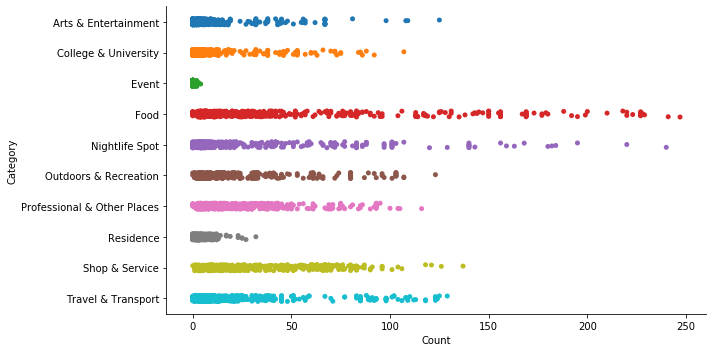

In [125]:
places_stacked = places.set_index('Location').stack().reset_index()
places_stacked.columns = ['Location', 'Category', 'Count']
sns.catplot(x="Count", y="Category", orient="h", aspect=2, data=places_stacked);

#### Let's normalize data to 0 - 1 scale

In [126]:
places_normalized = places.set_index('Location')
places_normalized = places_normalized.div(places_normalized.max())
places_normalized = places_normalized.reset_index()
places_normalized

,Location,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,Abbey Wood,0.008,0.000000,0.0,0.024291,0.025000,0.040650,0.025862,0.06250,0.051095,0.031008
1,Acton,0.032,0.046729,0.0,0.246964,0.058333,0.097561,0.327586,0.18750,0.481752,0.232558
2,Addington,0.000,0.000000,0.0,0.024291,0.004167,0.040650,0.034483,0.00000,0.021898,0.023256
3,Addiscombe,0.040,0.065421,0.0,0.214575,0.104167,0.065041,0.310345,0.18750,0.598540,0.248062
4,Albany Park,0.008,0.018692,0.0,0.020243,0.020833,0.016260,0.051724,0.00000,0.124088,0.015504
...,...,...,...,...,...,...,...,...,...,...,...
528,Woolwich,0.048,0.102804,0.0,0.125506,0.045833,0.105691,0.198276,0.25000,0.116788,0.108527
529,Worcester Park,0.016,0.000000,0.0,0.048583,0.016667,0.016260,0.060345,0.03125,0.138686,0.031008
530,Wormwood Scrubs,0.072,0.037383,0.0,0.457490,0.166667,0.268293,0.344828,0.31250,0.437956,0.147287
531,Yeading,0.000,0.018692,0.0,0.020243,0.012500,0.016260,0.043103,0.00000,0.116788,0.023256


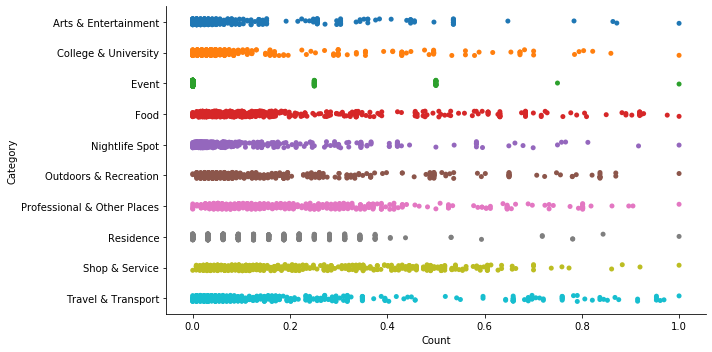

In [127]:
places_stacked = places_normalized.set_index('Location').stack().reset_index()
places_stacked.columns = ['Location', 'Category', 'Count']
sns.catplot(x="Count", y="Category", orient="h", aspect=2, data=places_stacked);

#### Now we will explore N most common values at every location

In [128]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [15]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Location']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))    

In [16]:
location_venues_sorted = pd.DataFrame(columns=columns)
location_venues_sorted['Location'] = places_normalized['Location']

In [17]:
for ind in np.arange(places_normalized.shape[0]):
    location_venues_sorted.iloc[ind, 1:] = return_most_common_venues(places_normalized.iloc[ind, :], num_top_venues)

location_venues_sorted.head()

,Location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Abbey Wood,Residence,Shop & Service,Outdoors & Recreation,Travel & Transport,Professional & Other Places
1,Acton,Shop & Service,Professional & Other Places,Food,Travel & Transport,Residence
2,Addington,Outdoors & Recreation,Professional & Other Places,Food,Travel & Transport,Shop & Service
3,Addiscombe,Shop & Service,Professional & Other Places,Travel & Transport,Food,Residence
4,Albany Park,Shop & Service,Professional & Other Places,Nightlife Spot,Food,College & University


### Clustering Locations
We will use K-Means algorithm to cluster locations.

In [18]:
places_clustering = places_normalized.drop('Location', 1)

#### First we need to find an optimal k
There are two methods we can try: Elbow and Silhouette

**The Elbow Method**- calculate the sum of squared distances of samples to their closest cluster center for different values of k. The value of k after which there is no siginificant decrease in sum of squared distances is choosen.

In [19]:
sum_of_squared_distances = []
K = range(1,20)
for k in K:
    print(k, end=' ')
    kmeans = KMeans(n_clusters=k).fit(places_clustering)
    sum_of_squared_distances.append(kmeans.inertia_)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 

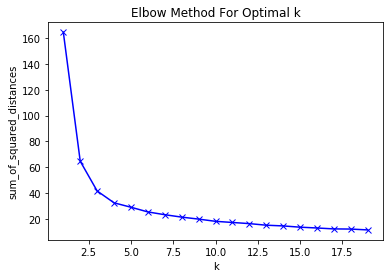

In [20]:
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('sum_of_squared_distances')
plt.title('Elbow Method For Optimal k');

It looks like we have an elbow point at k = 4 or k = 5. But let's see if another method gives a better result.

**The Silhouette Method** - The silhouette value measures how similar a point is to its own cluster (cohesion) compared to other clusters (separation).

In [21]:
sil = []
K_sil = range(2,20)
# minimum 2 clusters required, to define dissimilarity
for k in K_sil:
    print(k, end=' ')
    kmeans = KMeans(n_clusters = k).fit(places_clustering)
    labels = kmeans.labels_
    sil.append(silhouette_score(places_clustering, labels, metric = 'euclidean'))

2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 

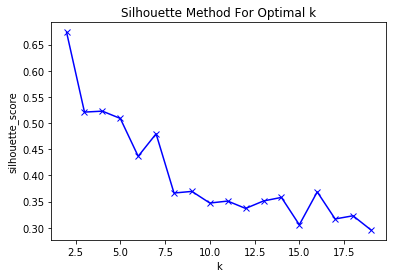

In [24]:
plt.plot(K_sil, sil, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette_score')
plt.title('Silhouette Method For Optimal k')
plt.show()

We local maximums at: 4,7, 10.
So let's try 4.

In [25]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(init="k-means++", n_clusters=kclusters, n_init=50).fit(places_clustering)

print(Counter(kmeans.labels_))

Counter({0: 330, 3: 134, 2: 51, 1: 18})


In [26]:
# add clustering labels
try:
    location_venues_sorted.drop('Cluster Labels', axis=1)
except:
    location_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [27]:
# merge venues with location data to add latitude/longitude
places_merged = location_venues_sorted.join(df_locations.set_index('Location'), on='Location')
places_merged.head(5)

,Cluster Labels,Location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Town,Postcode,Lat,Lng
0,0,Abbey Wood,Residence,Shop & Service,Outdoors & Recreation,Travel & Transport,Professional & Other Places,Bexley,LONDON,SE2,51.4925,0.12127
1,3,Acton,Shop & Service,Professional & Other Places,Food,Travel & Transport,Residence,Ealing,LONDON,W3,51.5181,-0.301954
2,0,Addington,Outdoors & Recreation,Professional & Other Places,Food,Travel & Transport,Shop & Service,Croydon,CROYDON,CR0,51.3588,-0.0329062
3,3,Addiscombe,Shop & Service,Professional & Other Places,Travel & Transport,Food,Residence,Croydon,CROYDON,CR0,51.3736,-0.0903331
4,0,Albany Park,Shop & Service,Professional & Other Places,Nightlife Spot,Food,College & University,Bexley,BEXLEY,DA5,51.4357,0.12588


#### And here are out clusters on the map:

In [28]:
places_merged['Cluster'] = places_merged["Cluster Labels"].apply(lambda x: str(x))
fig = px.scatter_mapbox(places_merged, lat="Lat", lon="Lng", hover_name="Location", hover_data=["Borough", "Town", "Cluster", "1st Most Common Venue", "2nd Most Common Venue"],
                        color="Cluster", zoom=9, height=600)
fig.update_traces(marker=dict(size=12))
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

# 5. Results
Let's have a closer look at the clusters.

We will define some columns to get statistics on:

In [56]:
required_column_indices = [2,3,7]
required_column = [list(places_merged.columns.values)[i] for i in required_column_indices]
required_column

['1st Most Common Venue', '2nd Most Common Venue', 'Borough']

## Cluster 0

In [57]:
cluster_0 = places_merged.loc[places_merged['Cluster Labels'] == 0, places_merged.columns[1:12]]
cluster_0.head(5)

,Location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Town,Postcode,Lat,Lng
0,Abbey Wood,Residence,Shop & Service,Outdoors & Recreation,Travel & Transport,Professional & Other Places,Bexley,LONDON,SE2,51.4925,0.12127
2,Addington,Outdoors & Recreation,Professional & Other Places,Food,Travel & Transport,Shop & Service,Croydon,CROYDON,CR0,51.3588,-0.0329062
4,Albany Park,Shop & Service,Professional & Other Places,Nightlife Spot,Food,College & University,Bexley,BEXLEY,DA5,51.4357,0.12588
5,Aldborough Hatch,Shop & Service,Professional & Other Places,Outdoors & Recreation,College & University,Travel & Transport,Redbridge,ILFORD,IG2,51.563,0.0917635
8,Alperton,Professional & Other Places,Residence,Shop & Service,Travel & Transport,Food,Brent,WEMBLEY,HA0,51.5342,-0.302984


In [58]:
for col in required_column:
    print(cluster_0[col].value_counts(ascending = False))
    print("---------------------------------------------")

Shop & Service                 138
Professional & Other Places     88
Residence                       65
Outdoors & Recreation           19
Travel & Transport              10
Event                            9
College & University             6
Food                             2
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Professional & Other Places    115
Shop & Service                  76
Residence                       66
Outdoors & Recreation           31
Travel & Transport              17
Food                            16
College & University            13
Event                            2
Arts & Entertainment             1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Barnet                    36
Bromley                   35
Bexley                    30
Havering                  21
Croydon                   18
Hillingdon                17
Brent                     16
Redbridge                 

We can see that this cluster has Shops, Professional places and Residences.
Given that no other cluster has that many residences it looks like a distinction feature of that claster.

## Cluster 1

In [59]:
cluster_1 = places_merged.loc[places_merged['Cluster Labels'] == 1, places_merged.columns[1:12]]
cluster_1.head(5)

,Location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Town,Postcode,Lat,Lng
1,Acton,Shop & Service,Professional & Other Places,Food,Travel & Transport,Residence,Ealing,LONDON,W3,51.5181,-0.301954
3,Addiscombe,Shop & Service,Professional & Other Places,Travel & Transport,Food,Residence,Croydon,CROYDON,CR0,51.3736,-0.0903331
16,Balham,Shop & Service,Professional & Other Places,Outdoors & Recreation,Travel & Transport,Food,Wandsworth,LONDON,SW12,51.4568,-0.19452
27,Battersea,Shop & Service,Professional & Other Places,Food,Travel & Transport,Residence,Wandsworth,LONDON,SW11,51.4592,-0.173079
36,Bellingham,Shop & Service,Residence,Professional & Other Places,Travel & Transport,Outdoors & Recreation,Lewisham,LONDON,SE6,51.4592,-0.01213


In [60]:
for col in required_column:
    print(cluster_1[col].value_counts(ascending = False))
    print("---------------------------------------------")

Shop & Service                 101
Professional & Other Places     21
Food                             7
Travel & Transport               6
Residence                        3
College & University             1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Professional & Other Places    58
Food                           36
Shop & Service                 17
Residence                      13
Outdoors & Recreation           7
Travel & Transport              6
Event                           2
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Tower Hamlets                                   18
Hackney                                         15
Lewisham                                        13
Haringey                                        10
Wandsworth                                       9
Hammersmith and Fulham                           8
Richmond upon Thames                             7
Camden             

This one has mostly Shops and **Professional** places. We can assume it's a business area of London.

## Cluster 2

In [75]:
cluster_2 = places_merged.loc[places_merged['Cluster Labels'] == 2, places_merged.columns[1:12]]
cluster_2.head(5)

,Location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Town,Postcode,Lat,Lng
6,Aldgate,Outdoors & Recreation,Food,Travel & Transport,Nightlife Spot,Professional & Other Places,City,LONDON,EC3,51.5133,-0.0777621
17,Bankside,Food,Travel & Transport,Professional & Other Places,Outdoors & Recreation,Shop & Service,Southwark,LONDON,SE1,51.5082,-0.09523
18,Barbican,Outdoors & Recreation,Food,Nightlife Spot,Travel & Transport,Residence,City,LONDON,EC1,51.5201,-0.09247
41,Bermondsey,Food,Outdoors & Recreation,Travel & Transport,Professional & Other Places,Shop & Service,Southwark,LONDON,SE1,51.5057,-0.0892393
49,Blackfriars,Food,Nightlife Spot,Professional & Other Places,Outdoors & Recreation,Travel & Transport,City,LONDON,EC4,51.512,-0.10356


In [76]:
for col in required_column:
    print(cluster_2[col].value_counts(ascending = False))
    print("---------------------------------------------")

Food                           10
Outdoors & Recreation           3
Shop & Service                  1
Professional & Other Places     1
Travel & Transport              1
College & University            1
Arts & Entertainment            1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Outdoors & Recreation          7
Food                           5
Professional & Other Places    3
Nightlife Spot                 1
Travel & Transport             1
College & University           1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Southwark        9
City             4
Camden           3
Tower Hamlets    1
Westminster      1
Name: Borough, dtype: int64
---------------------------------------------


This one has mostly Food and **Recreation**. Looks like a usual city center for Londoners.

## Cluster 3

In [65]:
cluster_3 = places_merged.loc[places_merged['Cluster Labels'] == 3, places_merged.columns[1:12]]
cluster_3.head(5)

,Location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Town,Postcode,Lat,Lng
7,Aldwych,Professional & Other Places,Food,Travel & Transport,Outdoors & Recreation,Arts & Entertainment,Westminster,LONDON,WC2,51.5001,-0.12802
10,Angel,Food,Shop & Service,College & University,Outdoors & Recreation,Travel & Transport,Islington,LONDON,EC1,51.532,-0.10626
12,Archway,Food,Outdoors & Recreation,College & University,Shop & Service,Travel & Transport,Islington,LONDON,N19,51.5328,-0.10614
26,Barnsbury,Food,Shop & Service,Travel & Transport,Outdoors & Recreation,Nightlife Spot,Islington,LONDON,N1,51.5365,-0.11091
28,Bayswater,Professional & Other Places,Food,Travel & Transport,Outdoors & Recreation,Arts & Entertainment,Westminster,LONDON,W2,51.5001,-0.12802


In [66]:
for col in required_column:
    print(cluster_3[col].value_counts(ascending = False))
    print("---------------------------------------------")

Travel & Transport             16
Food                           16
Professional & Other Places    12
Residence                       3
Shop & Service                  2
Outdoors & Recreation           1
College & University            1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Food                           16
Outdoors & Recreation          12
Shop & Service                  6
Travel & Transport              6
College & University            6
Professional & Other Places     5
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Westminster               18
Islington                 14
Camden                     7
Kensington and Chelsea     5
Tower Hamlets              2
Camden and Islington       1
Islington                  1
Hammersmith and Fulham     1
Lambeth                    1
Southwark                  1
Name: Borough, dtype: int64
---------------------------------------------


And this one is Food and Travel. Guess **Tourism**.

#### Named Clusters on the map

In [29]:
cluster_names = [
    'Residential',
    'Professional',
    'Recreational',
    'Tourist',
]

places_clusters_named = places_merged.copy()
places_clusters_named['Cluster'] = places_clusters_named["Cluster Labels"].apply(lambda x: cluster_names[x])

In [30]:
fig = px.scatter_mapbox(places_clusters_named, lat="Lat", lon="Lng", hover_name="Location", hover_data=["Borough", "Town"],
                        color="Cluster", zoom=9, height=600)
fig.update_traces(marker=dict(size=12), line=dict(width=2,
                                        color='DarkSlateGrey'))
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

# 6. Discussion
Foursquare data is not fair for all categories. Some, like Food, dominate others. Size of the place is not taken into account too.

# 7. Conclusion

Foursquare data together with unsupervised learning can give useful insights into a city structure.